In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction.text import CountVectorizer
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv('../data/weather_train_merged.csv')
df['date'] = pd.to_datetime(df['date'])

Let's first start off our feature engineering by taking a look at the correlation within our merged dataframe.

In [3]:
def plot_heatmap(df):
    plt.figure(figsize=(22,22))

    mask = np.zeros_like(df.corr(), dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(df.corr(), mask=mask, annot=True, 
                annot_kws={'size': 13}, cmap='coolwarm', 
                vmin=-1, vmax=1, square=True, fmt='.1g', 
                cbar_kws={'shrink':0.8}, center=0);

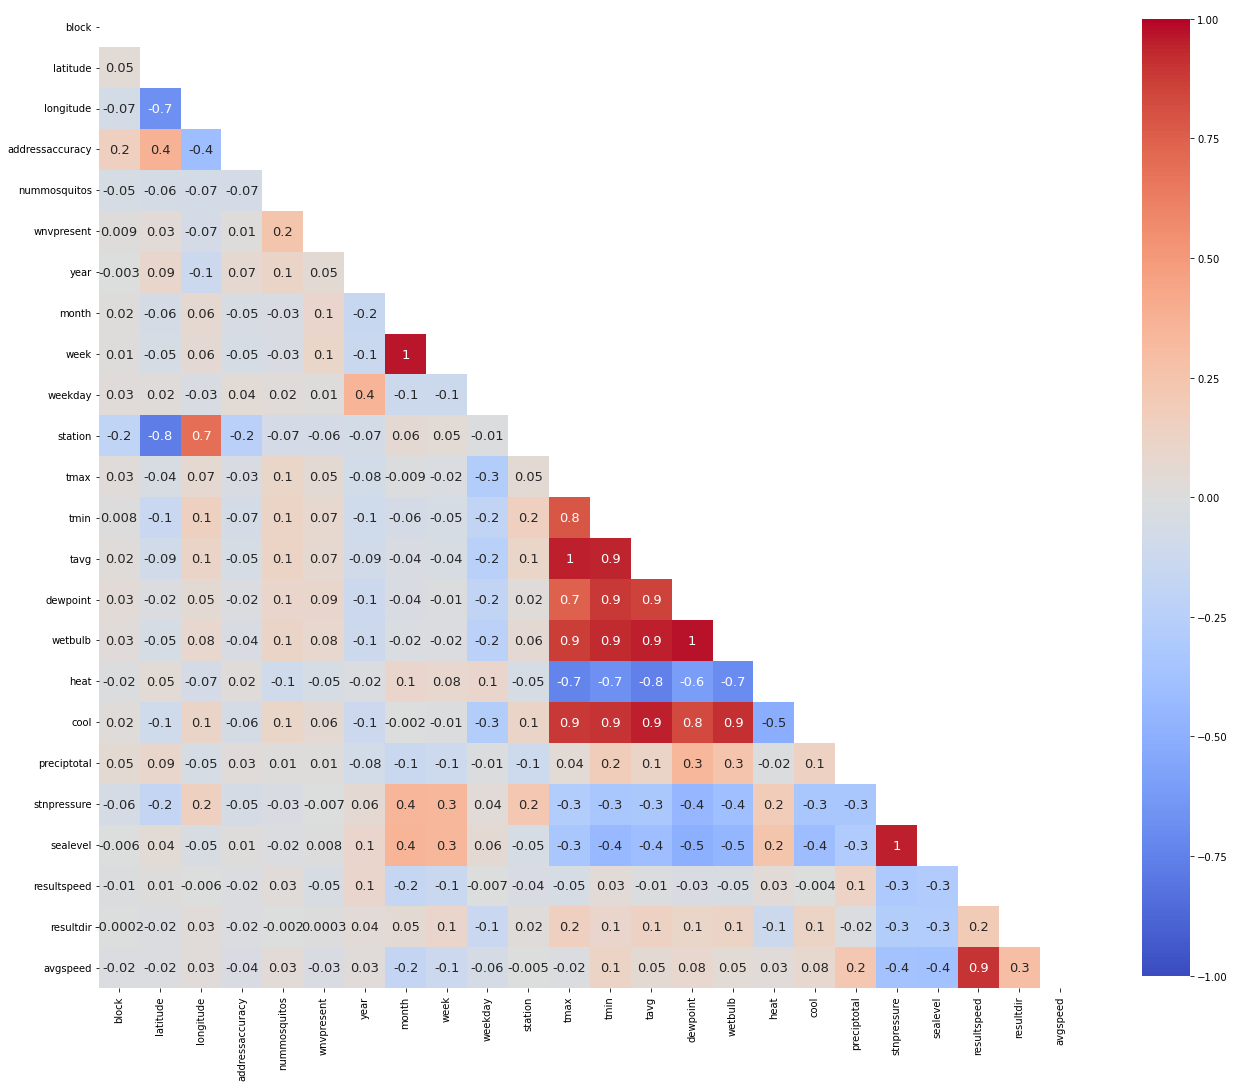

In [4]:
plot_heatmap(df)

From the above, we can see that most of our features have very low correlation with our target `wnvpresent`. The highest correlation observed is of a value of 0.1. As such, we will attempt some feature engineering to increase the correlation of our features. <br>

Additionally, we will use the above heatmap to conduct a preliminary feature selection process, and refer back to this heatmap to remove any features with pairwise correlation. An example of this would be `dewpoint` and `wetbulb`. 

In [5]:
abs(df.corr()['wnvpresent']).sort_values(ascending=False)

wnvpresent         1.000000
nummosquitos       0.248242
week               0.104807
month              0.101115
dewpoint           0.087043
wetbulb            0.082887
tmin               0.070538
longitude          0.068600
tavg               0.065243
station            0.063496
cool               0.059307
heat               0.054685
year               0.053875
tmax               0.051986
resultspeed        0.045893
latitude           0.033330
avgspeed           0.031990
preciptotal        0.014298
addressaccuracy    0.012268
weekday            0.011084
block              0.009204
sealevel           0.007648
stnpressure        0.006849
resultdir          0.000253
Name: wnvpresent, dtype: float64

We can see that there are some features missing from this list, like `trap`. We will address those categorical features at the end of the feature engineering process for the numerical features.

First we will drop any features that have an absolute correlation lesser than 2 percent.

In [6]:
features = abs(df.corr()['wnvpresent']).sort_values(ascending=False)
cols_to_drop = features[features < 0.02].index

In [7]:
df.drop(columns=cols_to_drop, inplace=True)

In [8]:
features = abs(df.corr()['wnvpresent']).sort_values(ascending=False)
features

wnvpresent      1.000000
nummosquitos    0.248242
week            0.104807
month           0.101115
dewpoint        0.087043
wetbulb         0.082887
tmin            0.070538
longitude       0.068600
tavg            0.065243
station         0.063496
cool            0.059307
heat            0.054685
year            0.053875
tmax            0.051986
resultspeed     0.045893
latitude        0.033330
avgspeed        0.031990
Name: wnvpresent, dtype: float64

With these remaining features, we will drop `latitude` and `longitude` and instead opt to use `trap` for our location feature. <br>
Based on pairwise correlation, we will opt to keep the feature that has higher correlation with our target `wnvpresent`. Below are the additional features we will drop, pairwise correlation is checked against the previously plotted heatmap. <br>
* `month`
* `wetbulb`
* `tmin`, `tmax`, `cool`, `heat`
* `station`, `latitude`, `longitude` (check with Daren and Dickson, our reasoning is that due to high correlation with lat and long, we can surmise that it will have high correlation with traps as well, therefore, we will opt to remove the feature. however we can potentially leave it in as long as not too high pairwise correlation with traps, what do you think?)
* `year` (as this will not be the same year in the test data, we will drop it, will check model performance with and without)
* `sunrise`, `sunset` (these two features will be closely related to the temperature features, so we will opt to use the temperature features as they are continuous variables)
* `address`, `street` (similar to the `station` feature, since we will one-hot encode the `trap` feature, we will opt to use just 1 location feature)
* `avgspeed` (since `avgspeed` and `resultspeed` have 90% pairwise correlation, we will opt to keep `resultspeed` which has a higher correlation (5%) with our target)

*even though `tavg` and `dewpoint` have a 90% pairwise correlation, we will keep both features as they measure heat and humidity respectively. Hopefully we are able to introduce an interaction element between them that has higher correlation with our target.*

In [9]:
df.drop(columns=['month', 'wetbulb', 'tmin', 
                 'tmax', 'cool', 'heat', 
                 'station', 'latitude', 'longitude', 
                 'year', 'sunrise', 'sunset', 
                 'address', 'street', 'addressnumberandstreet', 
                 'avgspeed'], inplace=True)

In [10]:
df.columns

Index(['date', 'species', 'trap', 'nummosquitos', 'wnvpresent', 'week', 'tavg',
       'dewpoint', 'codesum', 'resultspeed'],
      dtype='object')

In [11]:
features = abs(df.corr()['wnvpresent']).sort_values(ascending=False)
features

wnvpresent      1.000000
nummosquitos    0.248242
week            0.104807
dewpoint        0.087043
tavg            0.065243
resultspeed     0.045893
Name: wnvpresent, dtype: float64

Now we will turn to some of our external data research to help in feature engineering. 
- mosquitos take 7-14 days, up to months to hatch. For the purpose of our model, we will assume a 14 day period for mosquitos to hatch
- this means that temperatures, and humidity 14 days ago may have a high correlation with whether or not we detect WNV today. 
- as such we will create two new features as it may potentially have good correlation with our target. 
- They will be `tavg_minus_2w`, and `dewpoint_minus_2w`. 

In [12]:
# creating temp df to store results
weather_train_df = pd.read_csv('../data/weather_train_merged.csv')
weather_train_df['date'] = pd.to_datetime(weather_train_df['date'])
dates_station_temp = weather_train_df[['date','station','dewpoint','tavg']]

# lag datetime by 2 weeks

dates_station_temp['new_date'] = weather_train_df['date']-dt.timedelta(14)

C:\Users\JAYYJA~1\AppData\Local\Temp/ipykernel_11240/3437788581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_station_temp['new_date'] = weather_train_df['date']-dt.timedelta(14)


In [13]:
# function to impute 2 weeks ago dewpoint and tavg

def temp_2weeks_ago(row):
    
     try:
    
        weeks_date = row['new_date']
        
        weeks_station = row['station']
        
        weeks_dewpoint = dates_station_temp[(dates_station_temp['date'] == weeks_date) & (dates_station_temp['station'] == weeks_station)]['dewpoint'].iloc[0]
        
        weeks_tavg = dates_station_temp[(dates_station_temp['date'] == weeks_date) & (dates_station_temp['station'] == weeks_station)]['tavg'].iloc[0]
        
        row['dewpoint_minus_2w'] = weeks_dewpoint

        row['tavg_minus_2w'] = weeks_tavg
        
     except:
        
        row['dewpoint_minus_2w'] = np.nan

        row['tavg_minus_2w'] = np.nan
    
     return row

In [14]:
dates_station_temp = dates_station_temp.apply(temp_2weeks_ago,axis=1)

In [15]:
# getting the diff to impute those dates without temp 2 weeks ago

dates_station_temp['tavg_minus_diff'] =  dates_station_temp['tavg'] - dates_station_temp['tavg_minus_2w']

dates_station_temp['dewpoint_minus_diff'] = dates_station_temp['dewpoint'] - dates_station_temp['dewpoint_minus_2w']

In [16]:
# splitting by station and back filling 2 weeks differences values with the nearest 2 weeks diff before joining them again
dates_station_1 = dates_station_temp[dates_station_temp['station']==1].bfill()
dates_station_2 = dates_station_temp[dates_station_temp['station']==2].bfill()

dates_station_filled = pd.concat([dates_station_1,dates_station_2])

# function to repopulate diff

def impute_diff(row):
    row['tavg_minus_diff'] = dates_station_filled[(dates_station_filled['date']==row['date']) & (dates_station_filled['station']==row['station'])]['tavg_minus_diff'].iloc[0]
    
    row['dewpoint_minus_diff'] = dates_station_filled[(dates_station_filled['date']==row['date']) & (dates_station_filled['station']==row['station'])]['dewpoint_minus_diff'].iloc[0]
    
    return row

In [17]:
dates_station_temp = dates_station_temp.apply(impute_diff,axis=1)

# after getting our estimated 2 weeks diff, we repopulate the temp and dewpoint 2 weeks ago

dates_station_temp['tavg_minus_2w'] = dates_station_temp['tavg'] - dates_station_temp['tavg_minus_diff']

dates_station_temp['dewpoint_minus_2w'] = dates_station_temp['dewpoint'] - dates_station_temp['dewpoint_minus_diff']

# transferring figures to our main df

df['tavg_minus_2w'] = dates_station_temp['tavg_minus_2w']

df['dewpoint_minus_2w'] = dates_station_temp['dewpoint_minus_2w']

Now that we have created the 2 additional features, let's take a look at our heatmap again to see if there is any improvement.

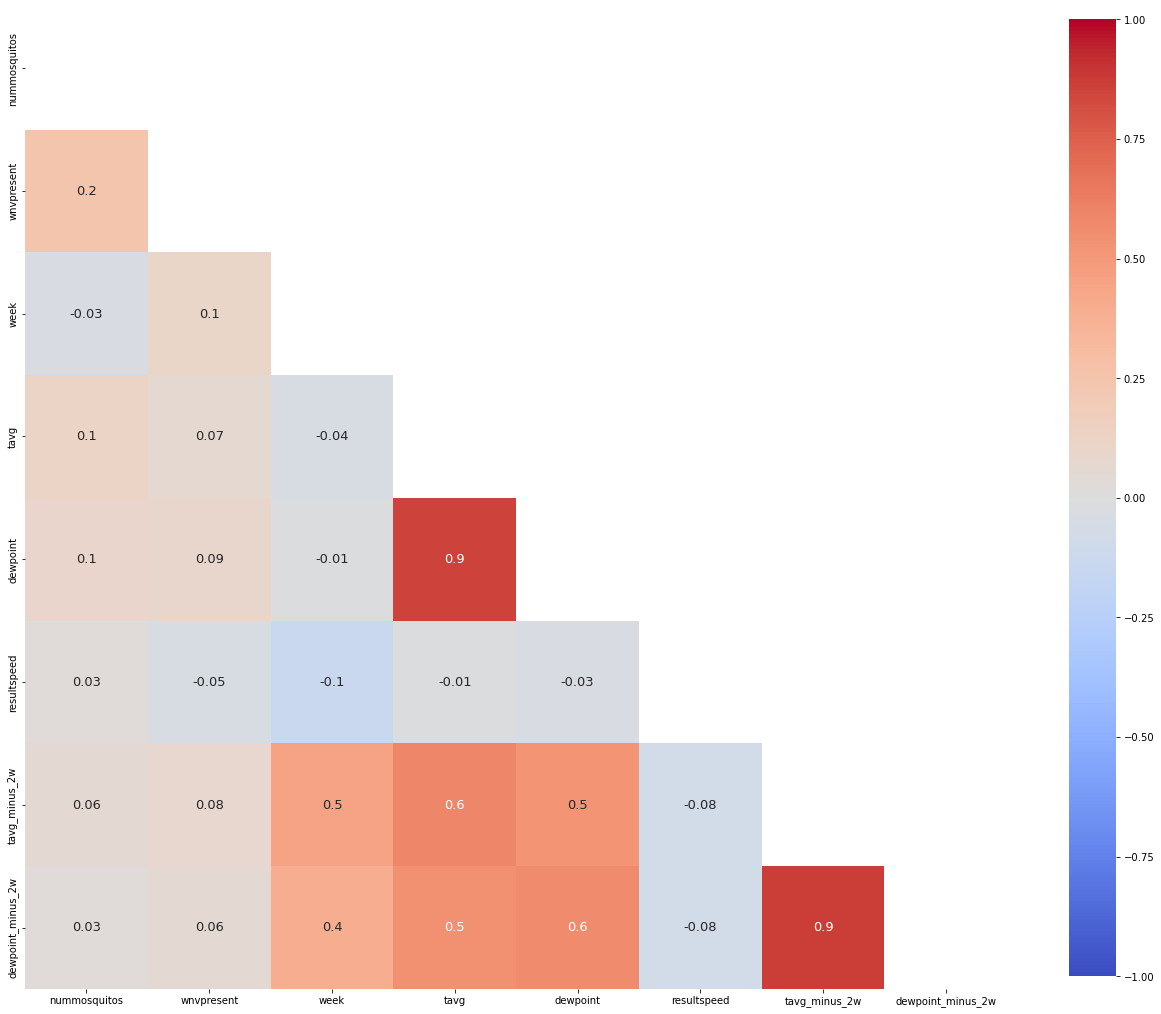

In [18]:
plot_heatmap(df)

Our two new features have a correlation score of 8% and 6% for `tavg_minus_2w` and `dewpoint_minus_2w` respectively.

Most of our features with 'high' correlation scores have scores between 5% - 10%. Let's see if we can make use of some `Polynomial` features to improve the potential correlation of our selected features with our target.

In [19]:
# list of numerical features in our DataFrame
num_df = df[['nummosquitos', 'week', 'tavg', 'dewpoint', 'resultspeed', 'tavg_minus_2w', 'dewpoint_minus_2w']]

We tested out multiple degrees for `polynomial features`, however we found that degree 2 works the best and the resultant features give us the highest correlation with our target.

In [20]:
# From our testing, we found that `degree=2` worked best
poly = PolynomialFeatures(include_bias=False, degree=2)
poly_features = poly.fit_transform(num_df)
poly_features.shape

(9693, 35)

In [21]:
poly_features = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(num_df.columns))

In [22]:
poly_corr = poly_features.corrwith(df['wnvpresent'])

In [23]:
abs(poly_corr).sort_values(ascending=False)

nummosquitos week                  0.274450
nummosquitos tavg_minus_2w         0.258605
nummosquitos dewpoint_minus_2w     0.258174
nummosquitos dewpoint              0.256252
nummosquitos tavg                  0.250958
nummosquitos                       0.248242
nummosquitos^2                     0.221420
nummosquitos resultspeed           0.184583
week dewpoint                      0.143741
week tavg                          0.130432
week tavg_minus_2w                 0.105639
week                               0.104807
week^2                             0.095842
dewpoint tavg_minus_2w             0.095333
week dewpoint_minus_2w             0.092057
dewpoint^2                         0.087627
dewpoint                           0.087043
tavg tavg_minus_2w                 0.080552
tavg dewpoint                      0.079799
dewpoint dewpoint_minus_2w         0.079039
tavg_minus_2w                      0.078887
tavg_minus_2w^2                    0.072698
tavg dewpoint_minus_2w          

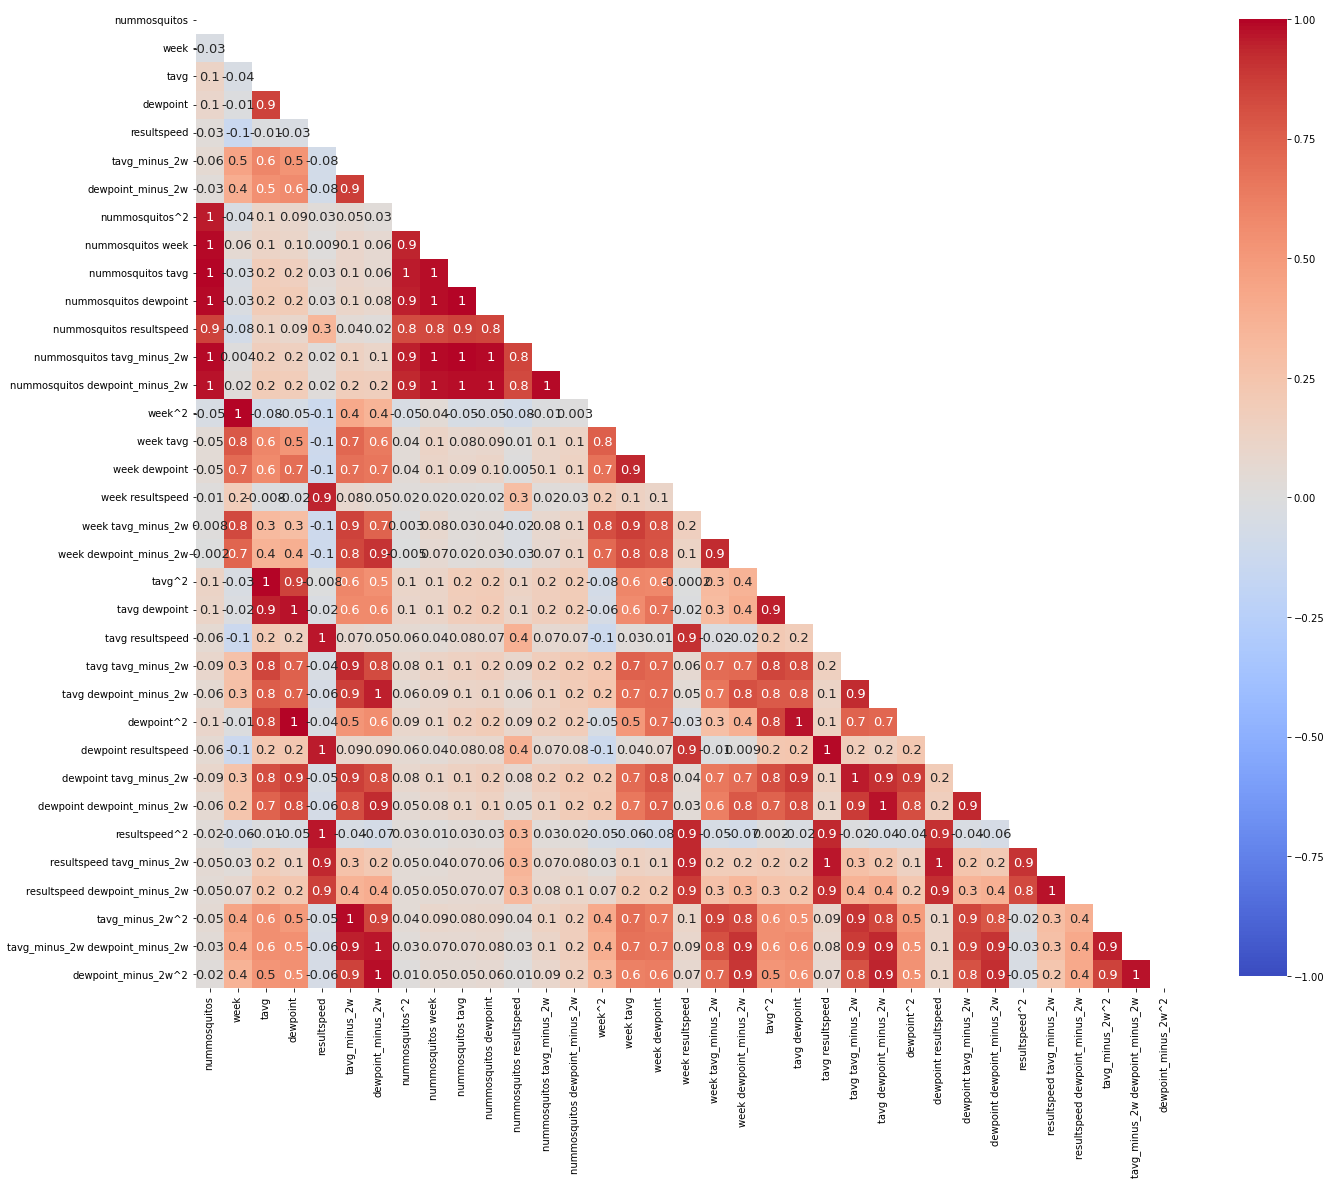

In [24]:
plot_heatmap(poly_features)

We seem to have found some very interesting features, with more than double the highest correlation that we saw. However there is clearly a lot of multicollinearity within these features, we will have to carefully select the feautures that we will add to our train dataset, with reference to the above heatmap as well as the series of feature names and correlation score.

We will select a couple of features from the above series, 1 from each 'category', (e.g. if we select `nummosquitos*week` we will not select any other `nummosquitos` feautures), and after comparison with the VIF score, we will drop those features that are causing a high level of multicollinearity. 

* nummosquitos week
* week dewpoint
* week tavg_minus_2w
* dewpoint tavg_minus_2w
* tavg dewpoint
* tavg dewpoint_minus_2w

In [25]:
# manually adding the selected polynomial features to our original DataFrame
df['nummosquitos*week'] = df['nummosquitos']*df['week']
df['week*dewpoint'] = df['week']*df['dewpoint']
df['week*tavg_minus_2w'] = df['week']*df['tavg_minus_2w']
df['dewpoint*tavg_minus_2w'] = df['dewpoint']*df['tavg_minus_2w']
df['tavg*dewpoint'] = df['tavg']*df['dewpoint']
df['tavg*dewpoint_minus_2w'] = df['tavg']*df['dewpoint_minus_2w']

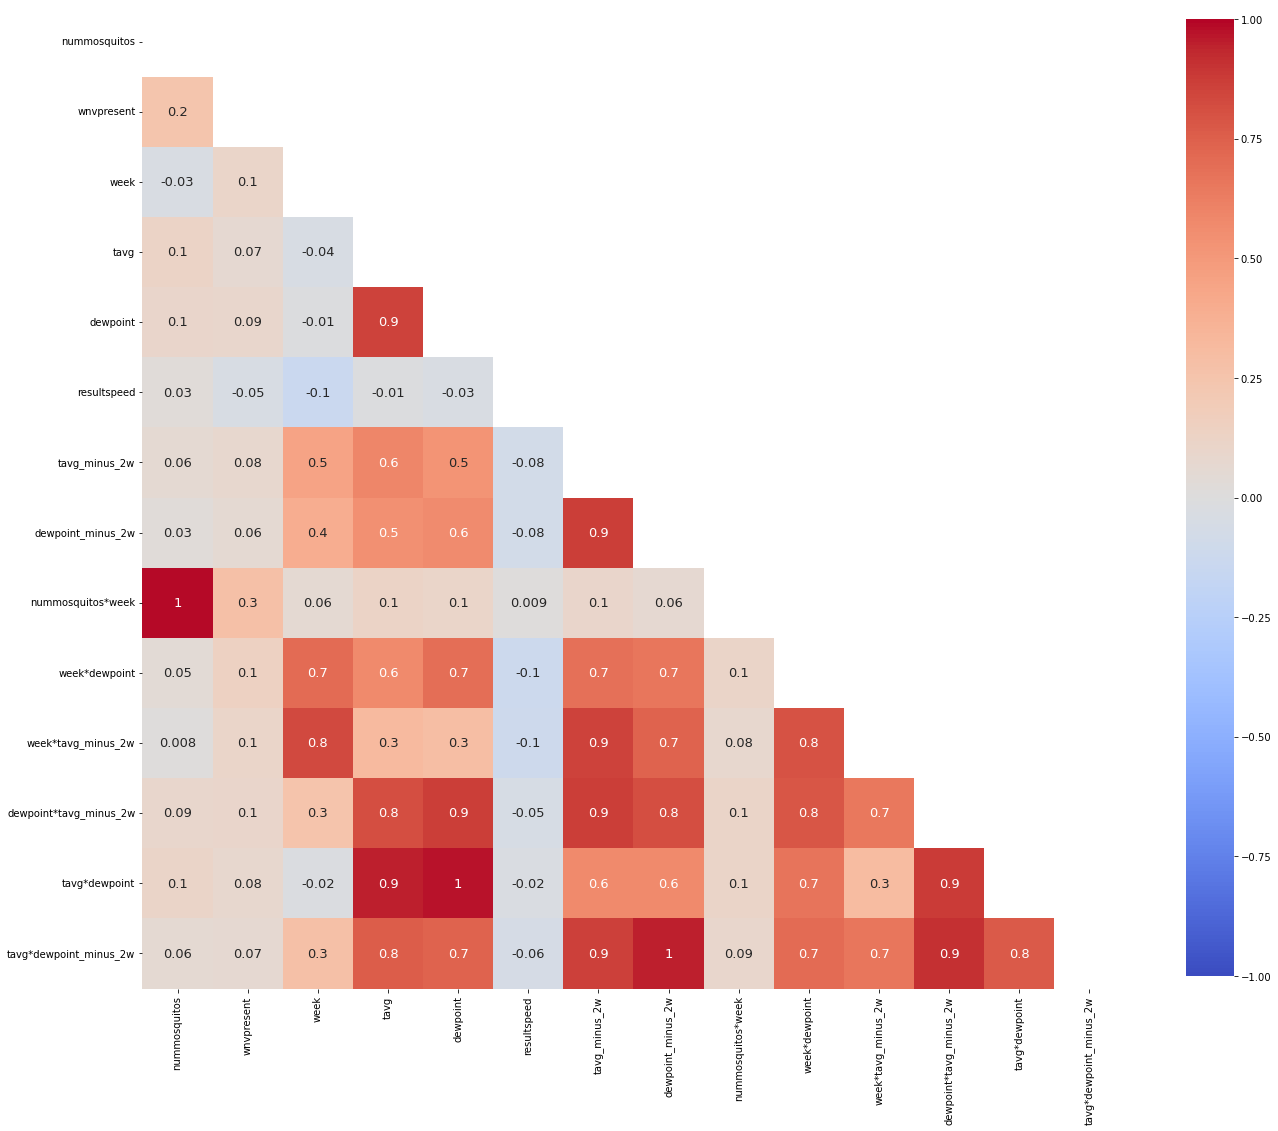

In [26]:
plot_heatmap(df)

As expected, we can see quite a bit of multi-collinearity. Let's take a look at the VIF scores.

In [27]:
# creating our X variable to pass into the VIF series
# we will drop the categorical features for this analysis
X = df.drop(columns=['wnvpresent', 'codesum', 
                     'date', 'trap', 'species']).assign(const=1)


# creating a Series to show all the VIF values
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

nummosquitos                66.319381
week                        87.065494
tavg                       152.360047
dewpoint                   433.457079
resultspeed                  1.086957
tavg_minus_2w              474.573602
dewpoint_minus_2w          443.866219
nummosquitos*week           66.448515
week*dewpoint              273.504228
week*tavg_minus_2w         185.972330
dewpoint*tavg_minus_2w     737.809058
tavg*dewpoint              363.429763
tavg*dewpoint_minus_2w     666.558426
const                     9799.493193
dtype: float64

After looking at the VIF scores, testing, and looking at the heatmap, we will proceed to drop the following features:
* `nummosquitos`
* `dewpoint`
* `tavg*dewpoint_minus_2w`
* `week*tavg_minus_2w`
* `tavg*dewpoint`
* `dewpoint*tavg_minus_2w`

In [28]:
df.drop(columns=['nummosquitos', 'dewpoint', 
                 'tavg*dewpoint_minus_2w', 'week*tavg_minus_2w', 
                 'tavg*dewpoint', 'dewpoint*tavg_minus_2w', 'dewpoint_minus_2w'], 
                inplace=True)

In [29]:
# creating our X variable to pass into the VIF series
# we will drop the categorical features for this analysis
X = df.drop(columns=['wnvpresent', 'codesum', 
                     'date', 'trap', 'species']).assign(const=1)


# creating a Series to show all the VIF values
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

week                   5.516695
tavg                   4.647159
resultspeed            1.021534
tavg_minus_2w          2.361443
nummosquitos*week      1.018389
week*dewpoint          7.436460
const                397.265199
dtype: float64

From here we can see that we have massively improved the VIF scores, thereby reducing a large amount of multi-collinearity in our model.

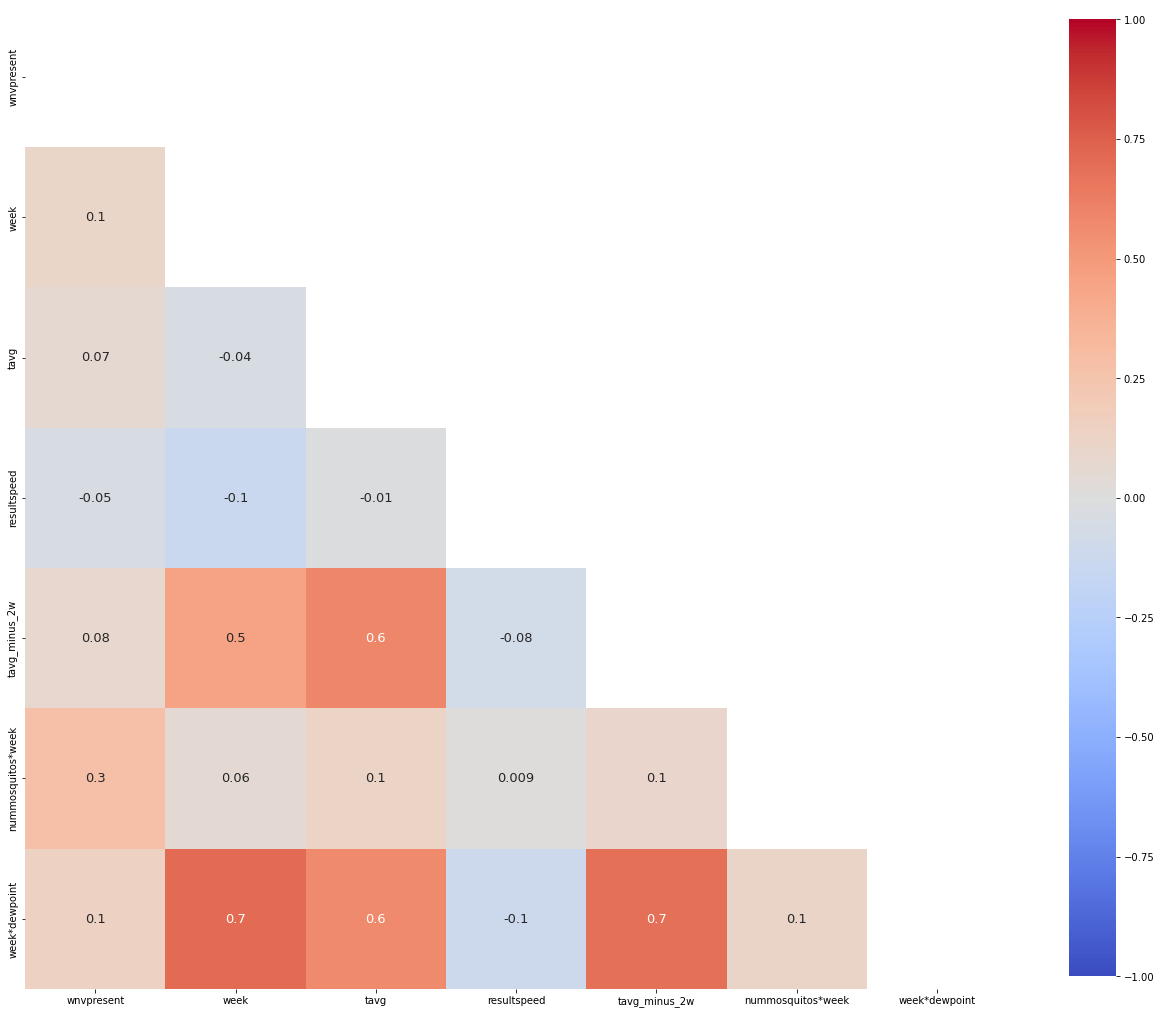

In [30]:
plot_heatmap(df)

Now with the numerical feature engineering done, we will proceed with dummification

---

## One-Hot Encoding / Dummifying

Now the last step for us to take is going to be one hot encoding, before we replicate the steps taken to the `test` data set.

### `Codesum`

In [31]:
# creating a new column for each weather condition
cvec = CountVectorizer()
cvec_df = pd.DataFrame(cvec.fit_transform(weather_train_df['codesum']).todense(),columns = cvec.get_feature_names_out())
# adding new columns into dataframe
df = pd.concat([weather_train_df,cvec_df],axis=1)
df = df.drop(['codesum'],axis=1)

### `Trap` and `Species`

In [32]:
df = pd.get_dummies(
    df,
    columns=['trap','species'],
    drop_first=True
)

And lastly we will drop the `date` feature from our DataFrame and with that we are ready to begin modeling.

In [33]:
df.drop(columns=['date'], inplace=True)

Now we are ready to use the `train` data to start modeling. Before we do that, we will replicate all the steps we took to our `test` data via a custom function.

In [34]:
def feature_engineering(df):
    df.drop(columns=['preciptotal', 'addressaccuracy', 
                     'weekday', 'block', 'sealevel',
                     'stnpressure', 'resultdir'],
           inplace=True)
    df.drop(columns=['month', 'wetbulb', 'tmin', 
                 'tmax', 'cool', 'heat', 
                 'station', 'latitude', 'longitude', 
                 'year', 'sunrise', 'sunset', 
                 'address', 'street', 'addressnumberandstreet', 
                 'avgspeed'], inplace=True)

Let's save our final merged `train` and `test` files.

In [35]:
df.to_csv('../data/train_final.csv', index=False)

However before we begin modeling, we will need to address the imbalance between our two classes using either an undersampling or oversampling technique. This will be covered in the next notebook.